In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="0eZ3KDGzb7FmLb4Yi2PY")
project = rf.workspace("kainat-qsyze").project("road_conditons")
version = project.version(5)
dataset = version.download("folder")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 3.5 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to road_conditons-5 in folder:: 100%|██████████| 499/499 [00:00<00:00, 5522.55it/s]


In [94]:
import os

def list_classes(directory):
    for root, dirs, _ in os.walk(directory):
        for dir_name in dirs:
            print(f"Class: {dir_name}")

train_dir = '/kaggle/working/road_conditons-5/train'
val_dir = '/kaggle/working/road_conditons-5/valid'

print("Training Classes:")
list_classes(train_dir)

print("\nValidation Classes:")
list_classes(val_dir)

           


Training Classes:
Class: right
Class: straight
Class: unexpected
Class: left

Validation Classes:
Class: right
Class: straight
Class: unexpected
Class: left


In [124]:
import os
import shutil

# Define the correct class names
correct_classes = ["right", "straight", "unexpected", "left"]

# Directories to inspect
train_dir = '/kaggle/working/road_conditons-5/train'
val_dir = '/kaggle/working/road_conditons-5/valid'

# Function to move images from incorrect to correct directories
def clean_classes(base_dir):
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if folder not in correct_classes and os.path.isdir(folder_path):
            print(f"Fixing folder: {folder}")
            # Move images to the correct class folders
            for file in os.listdir(folder_path):
                # Decide target folder based on the closest match (manual inspection might help)
                if "left" in folder:
                    target_folder = os.path.join(base_dir, "left")
                elif "straight" in folder:
                    target_folder = os.path.join(base_dir, "straight")
                elif "unexpected" in folder:
                    target_folder = os.path.join(base_dir, "unexpected")
                elif "right" in folder:
                    target_folder = os.path.join(base_dir, "right")
                else:
                    continue

                shutil.move(os.path.join(folder_path, file), target_folder)
            # Remove the empty incorrect folder
            shutil.rmtree(folder_path)

# Clean both train and validation directories
clean_classes(train_dir)
clean_classes(val_dir)

# Verify cleanup
print("\nAfter cleanup:")
print("Training Classes:")
for cls in os.listdir(train_dir):
    print(f"Class: {cls}")

print("\nValidation Classes:")
for cls in os.listdir(val_dir):
    print(f"Class: {cls}")



After cleanup:
Training Classes:
Class: right
Class: straight
Class: unexpected
Class: left

Validation Classes:
Class: right
Class: straight
Class: unexpected
Class: left


In [125]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Original dataset directory
original_dataset_dir = '/kaggle/working/road_conditons-5'

# New dataset directory (where train, valid, test folders will be created)
new_dataset_dir = '/kaggle/working/new_dataset'

# Class folders
classes = [folder for folder in os.listdir(os.path.join(original_dataset_dir, 'train')) if os.path.isdir(os.path.join(original_dataset_dir, 'train', folder))]

# Create new directories
for split in ['train', 'valid', 'test']:
    split_dir = os.path.join(new_dataset_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    for class_folder in classes:
        os.makedirs(os.path.join(split_dir, class_folder), exist_ok=True)

# Function to split and copy files
def split_and_copy_files(src_dir, train_dst_dir, valid_dst_dir, test_dst_dir, test_ratio=0.2, valid_ratio=0.2):
    for class_folder in classes:
        class_path = os.path.join(src_dir, class_folder)
        files = os.listdir(class_path)
        
        # First split: Training and Test set
        train_files, test_files = train_test_split(
            files, test_size=test_ratio, random_state=42
        )
        
        # Second split: Training and Validation set
        train_files, valid_files = train_test_split(
            train_files, test_size=valid_ratio, random_state=42
        )

        # Copy files to respective folders
        for file in train_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(train_dst_dir, class_folder, file))
        for file in valid_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(valid_dst_dir, class_folder, file))
        for file in test_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(test_dst_dir, class_folder, file))

# Apply splitting and copying
split_and_copy_files(
    src_dir=original_dataset_dir + '/train',
    train_dst_dir=os.path.join(new_dataset_dir, 'train'),
    valid_dst_dir=os.path.join(new_dataset_dir, 'valid'),
    test_dst_dir=os.path.join(new_dataset_dir, 'test')
)


In [126]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths to the new datasets
train_dir = '/kaggle/working/new_dataset/train'
val_dir = '/kaggle/working/new_dataset/valid'
test_dir = '/kaggle/working/new_dataset/test'

# Create data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)  # Validation set only requires rescaling
test_datagen = ImageDataGenerator(rescale=1.0/255) 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Ensure this matches your model input size
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 347 images belonging to 4 classes.
Found 129 images belonging to 4 classes.
Found 129 images belonging to 4 classes.


In [129]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Load pre-trained MobileNetV2 model without the classification head (top layer)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model layers to prevent them from being updated during the first training phase
base_model.trainable = False

# Add a custom classification head on top
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(4, activation='softmax')  # Adjust the number of classes for your dataset
])

# Compile the model with a learning rate scheduler
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define learning rate scheduler to reduce the learning rate when the validation loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    patience=3, 
    factor=0.1, 
    min_lr=1e-6
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights,
    callbacks=[lr_scheduler]
)


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 798ms/step - accuracy: 0.2639 - loss: 1.7891 - val_accuracy: 0.3488 - val_loss: 1.5124 - learning_rate: 1.0000e-04
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 0.2676 - loss: 1.5403 - val_accuracy: 0.3411 - val_loss: 1.4050 - learning_rate: 1.0000e-04
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - accuracy: 0.3222 - loss: 1.4939 - val_accuracy: 0.3333 - val_loss: 1.3618 - learning_rate: 1.0000e-04
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.3216 - loss: 1.4305 - val_accuracy: 0.3643 - val_loss: 1.3284 - learning_rate: 1.0000e-04
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - accuracy: 0.3957 - loss: 1.3826 - val_accuracy: 0.3953 - val_loss: 1.2940 - learning_rate: 1.0000e-04
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.4124 - loss: 1.3575 - val_accuracy: 0.4186 - val_loss: 1.2607 - learning_rate: 1.0000e-04
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy:

In [144]:
# Unfreeze the last few layers of the pre-trained MobileNetV2
for layer in base_model.layers[-50:]:  # Unfreeze last 10 layers
    layer.trainable = True

# Re-compile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # Adjust as needed
    class_weight=class_weights,
    callbacks=[lr_scheduler]  # You can keep using your learning rate scheduler if needed
)


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8224 - loss: 0.6126 - val_accuracy: 0.7442 - val_loss: 0.5786 - learning_rate: 1.0000e-05
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.8272 - loss: 0.6143 - val_accuracy: 0.7519 - val_loss: 0.5701 - learning_rate: 1.0000e-05
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.8339 - loss: 0.5834 - val_accuracy: 0.7597 - val_loss: 0.5607 - learning_rate: 1.0000e-05
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 0.8063 - loss: 0.5757 - val_accuracy: 0.7597 - val_loss: 0.5507 - learning_rate: 1.0000e-05
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.8123 - loss: 0.5755 - val_accuracy: 0.7597 - val_loss: 0.5377 - learning_rate: 1.0000e-05
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.8158 - loss: 0.5600 - val_accuracy: 0.7597 - val_loss: 0.5247 - learning_rate: 1.0000e-05
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.

In [145]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9295 - loss: 0.2791 
Test Accuracy: 0.91
Test Loss: 0.2986


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


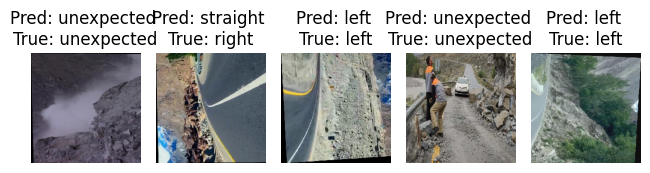

In [146]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure the test generator is not being iterated multiple times
test_images, test_labels = next(iter(test_generator))

# Make predictions for this batch
predictions = model.predict(test_images)

# Define the class names (replace with your actual class names list)
class_names = ['left', 'right', 'straight', 'unexpected']

# Plot a few images with predicted and true labels
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(test_images[i])
    predicted_label = class_names[np.argmax(predictions[i])]
    true_label = class_names[np.argmax(test_labels[i])]
    plt.title(f"Pred: {predicted_label} \nTrue: {true_label}")
    plt.axis('off')  # Hide axes for better visualization

plt.tight_layout()
plt.show()


In [147]:
from sklearn.metrics import classification_report
import numpy as np

# Initialize empty lists to hold the true labels and predictions
all_true_labels = []
all_pred_labels = []

# Define the number of steps to iterate over the generator
steps = len(test_generator)

# Iterate through the test set for a fixed number of steps
for _ in range(steps):
    images, labels = next(test_generator)
    
    # Get model predictions
    predictions = model.predict(images)
    
    # Convert predictions to class labels
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels, axis=1)
    
    # Append to the lists
    all_true_labels.extend(true_labels)
    all_pred_labels.extend(predicted_labels)

# Generate the classification report
report = classification_report(all_true_labels, all_pred_labels, target_names=class_names)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
              precision    recall  f1-score   support

        left       1.00      0.83      0.91        24
       right       0.81      0.85      0.83        34
    straight       0.86      0.97      0.91        33
  unexpected       1.00      0.95      0.97        38

    accuracy                           0.91       129
   macro avg       0.92      0.90      0.91       129
weighted avg       0.91      0.91      0.91       129



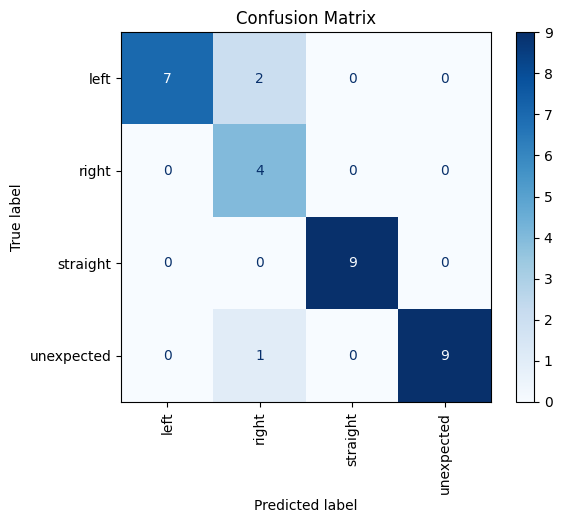

In [148]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_indices.keys())
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="0eZ3KDGzb7FmLb4Yi2PY")
project = rf.workspace("kainat-qsyze").project("road_turns")
version = project.version(1)
dataset = version.download("yolov8")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 2.4 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to road_turns-1 in yolov8:: 100%|██████████| 890/890 [00:00<00:00, 6979.91it/s]


In [2]:
pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.2/881.2 kB 19.5 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [20]:
from ultralytics import YOLO


In [21]:
model = YOLO('yolov8s.pt')  # Pre-trained small model


In [26]:
!yolo task=detect mode=train model=yolov8s.pt data= /kaggle/working/road_turns-1/data.yaml epochs=50 batch=16 imgsz=224 lr0=0.01 lrf=0.1 patience=20 plots=True

Ultralytics 8.3.28 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/road_turns-1/data.yaml, epochs=50, time=None, patience=20, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sho

In [27]:
!ls runs/detect/train10

F1_curve.png					   train_batch0.jpg
PR_curve.png					   train_batch1.jpg
P_curve.png					   train_batch2.jpg
R_curve.png					   train_batch920.jpg
args.yaml					   train_batch921.jpg
confusion_matrix.png				   train_batch922.jpg
confusion_matrix_normalized.png			   val_batch0_labels.jpg
events.out.tfevents.1731071019.77a536c69195.866.0  val_batch0_pred.jpg
labels.jpg					   val_batch1_labels.jpg
labels_correlogram.jpg				   val_batch1_pred.jpg
results.csv					   weights
results.png


In [28]:
!yolo task=detect mode=val model=runs/detect/train10/weights/best.pt data=/kaggle/working/road_turns-1/data.yaml


Ultralytics 8.3.28 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /kaggle/working/road_turns-1/valid/labels.cache... 40 images, 0 ba
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all         40         40      0.365      0.442       0.37      0.124
                  left          7          7      0.421      0.571      0.485       0.21
                 right          8          8      0.493        0.5      0.561      0.157
              straight         13         13      0.258      0.462       0.33      0.106
            unexpected         12         12      0.287      0.236      0.105     0.0234
Speed: 0.6ms preprocess, 7.6ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/val2
💡 Learn more at https://docs.ultralytics.com/modes/val


In [33]:
!ls runs/detect/val2


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


F1_curve.png  confusion_matrix.png	       val_batch1_labels.jpg
PR_curve.png  confusion_matrix_normalized.png  val_batch1_pred.jpg
P_curve.png   val_batch0_labels.jpg	       val_batch2_labels.jpg
R_curve.png   val_batch0_pred.jpg	       val_batch2_pred.jpg


In [29]:
!pip install pandas seaborn


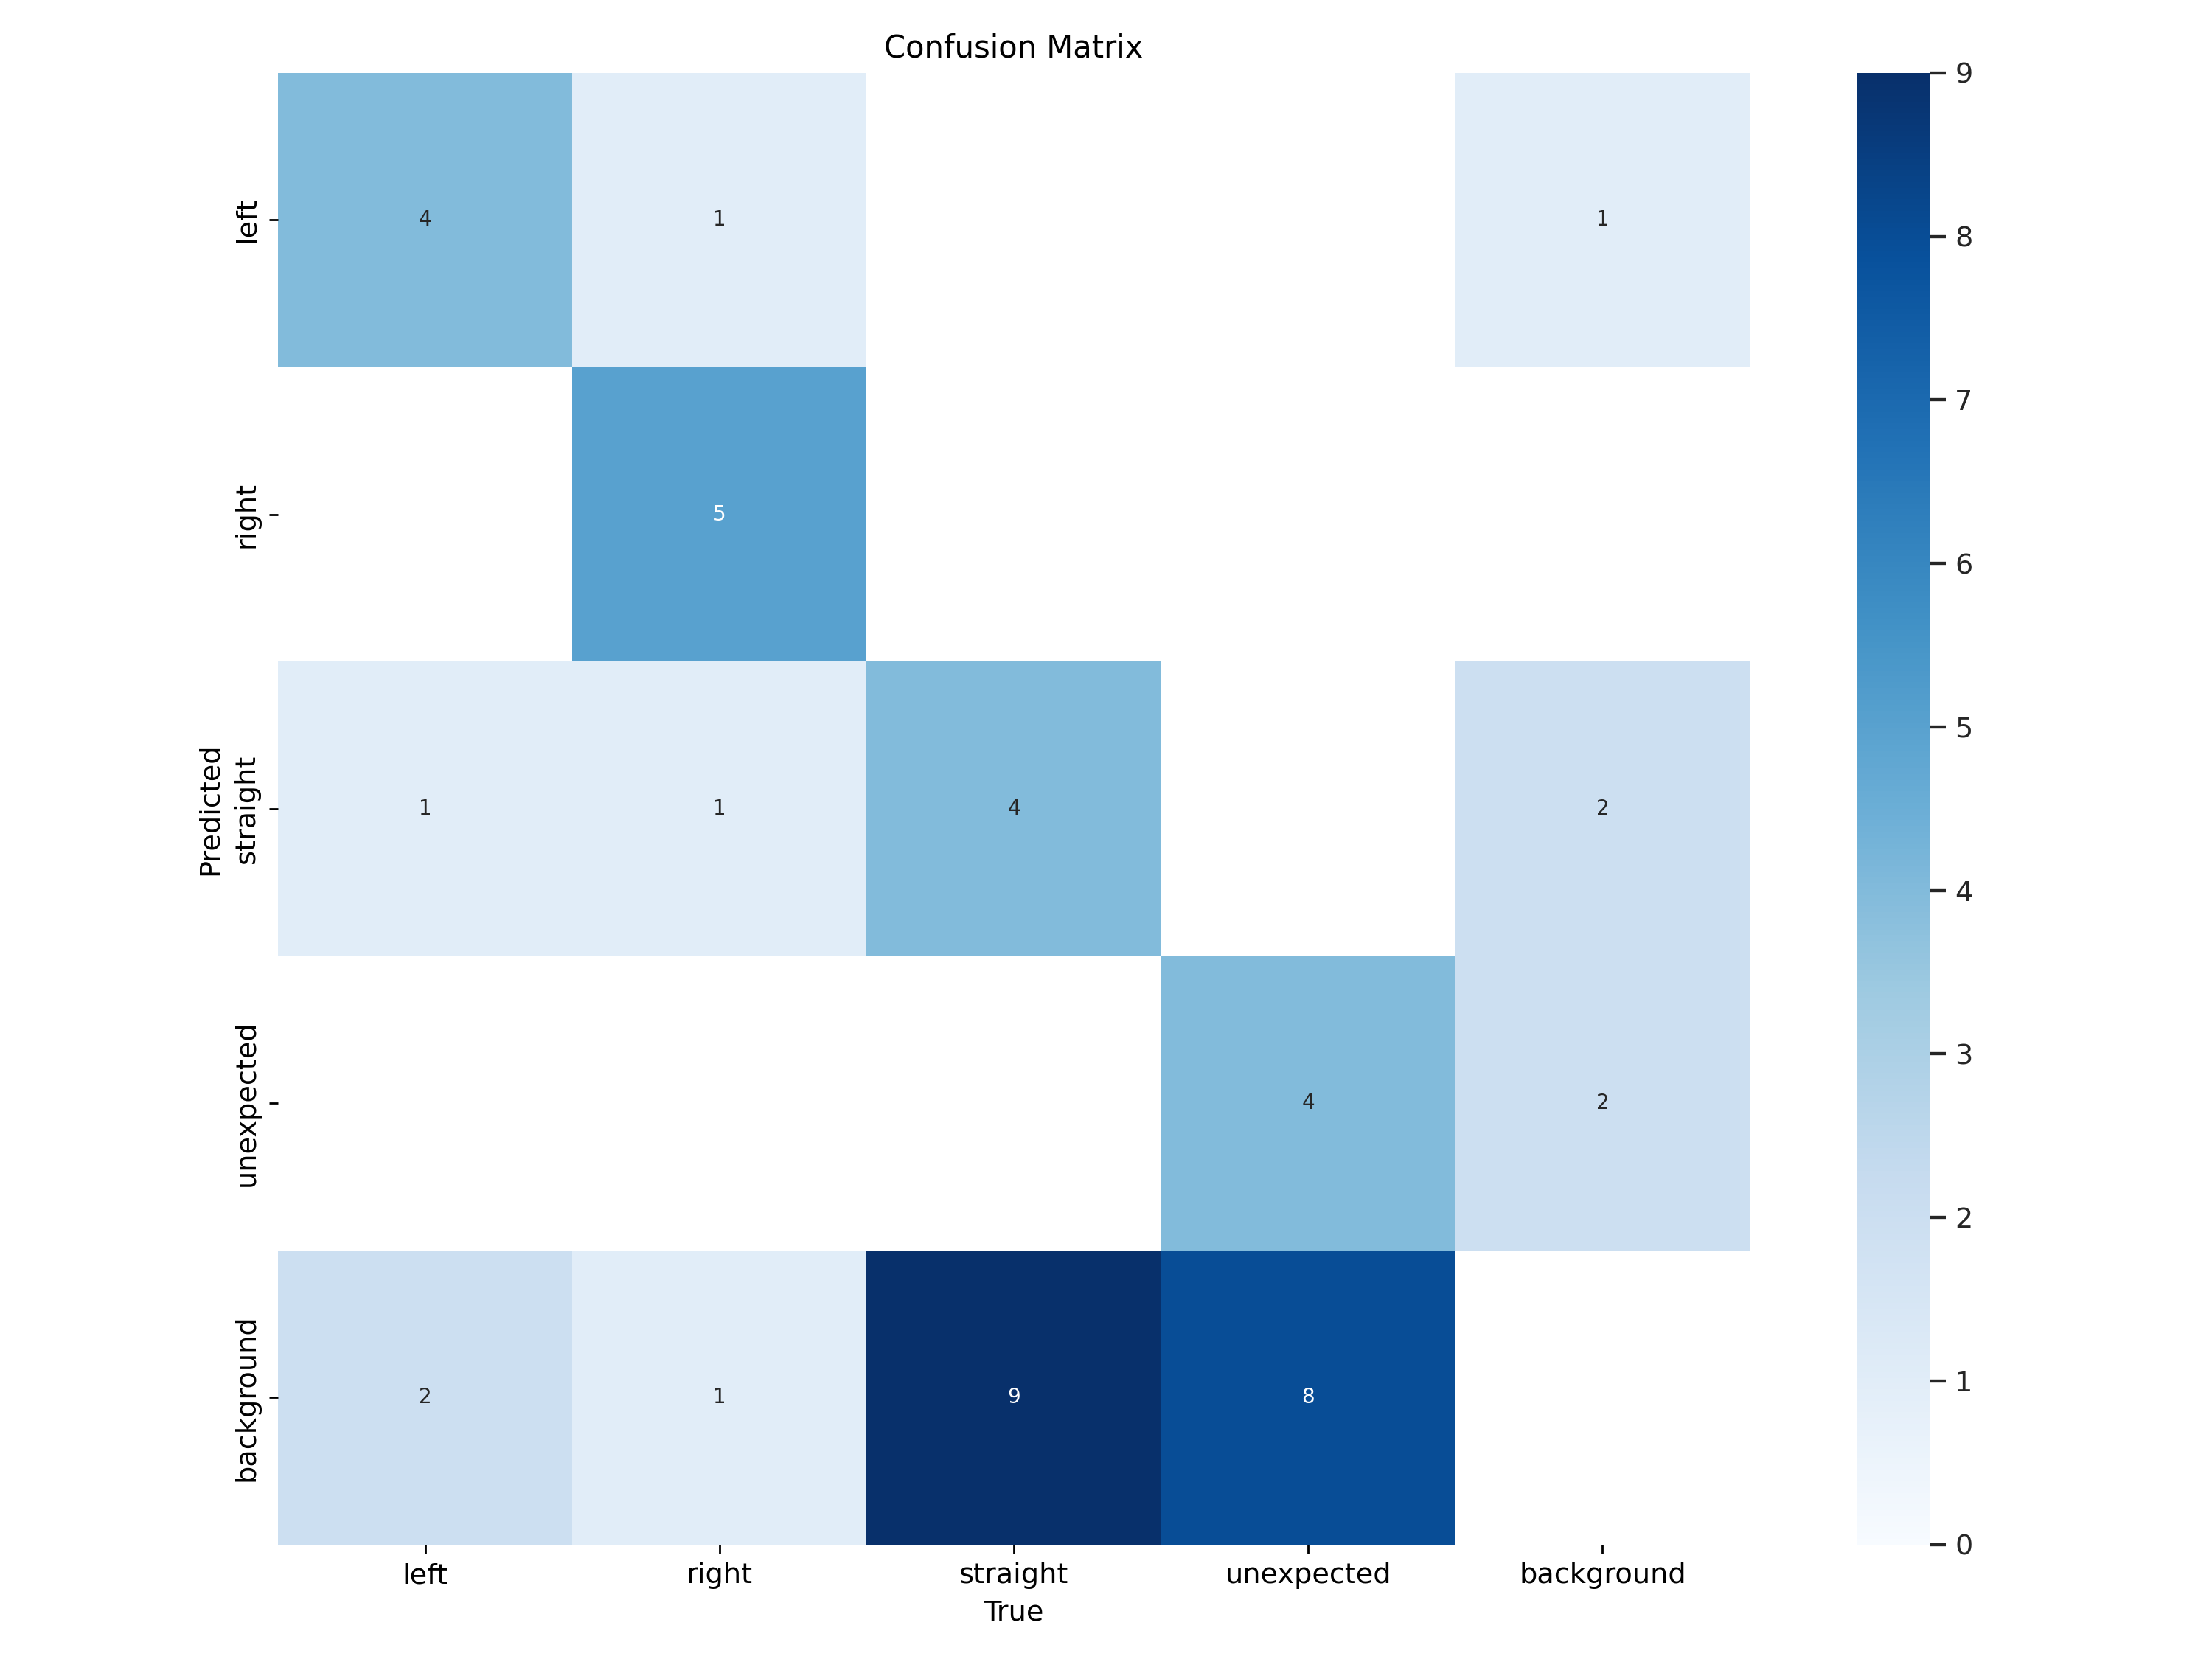

In [34]:
from IPython.display import Image, display

# Path to the confusion matrix image from the latest run
confusion_matrix_path = 'runs/detect/train10/confusion_matrix.png'  # Update this path if needed

# Display the confusion matrix image
display(Image(filename=confusion_matrix_path, width=600))


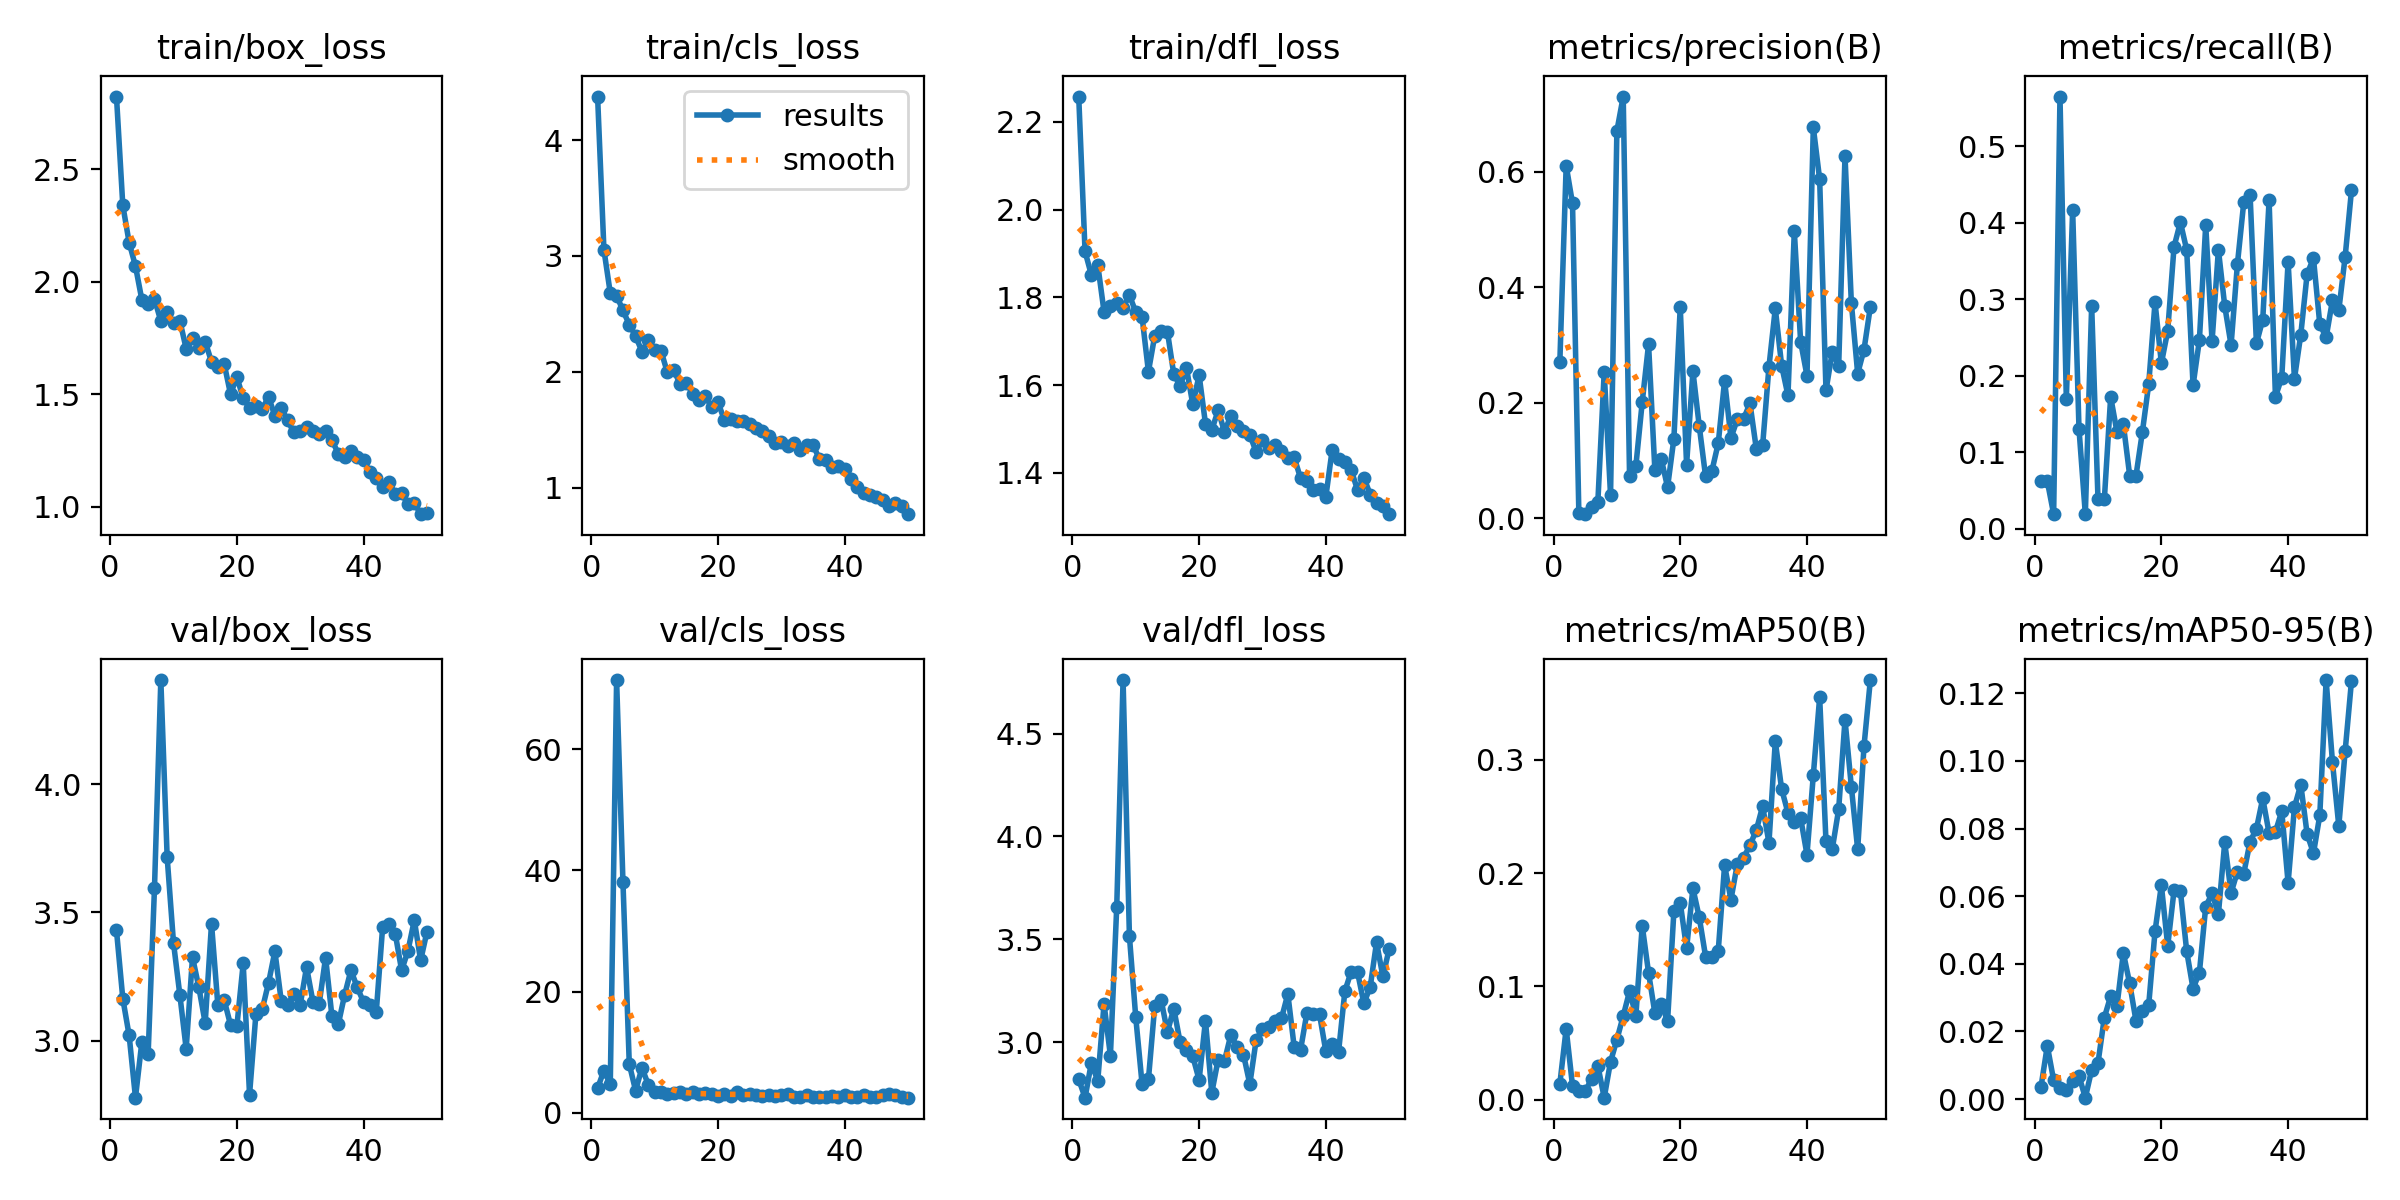

In [36]:
Image(filename='runs/detect/train10/results.png', width=600)

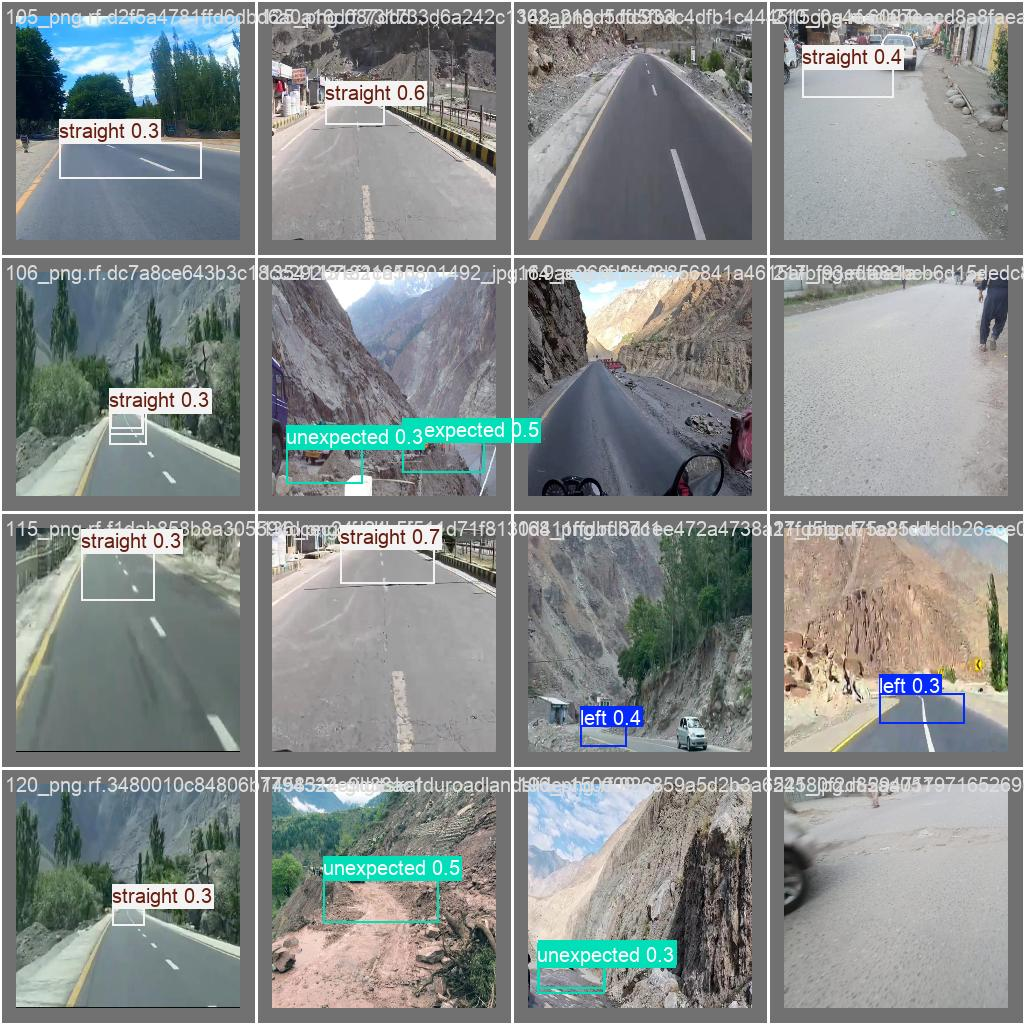

In [38]:
Image(filename='runs/detect/train10/val_batch0_pred.jpg', width=600)

In [45]:
!ls /kaggle/working/road_turns-1


README.dataset.txt  README.roboflow.txt  data.yaml  test  train  valid


In [46]:
!yolo task=detect mode=predict model=runs/detect/train10/weights/best.pt conf=0.25 source=/kaggle/working/road_turns-1/test/images


Ultralytics 8.3.28 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs

image 1/40 /kaggle/working/road_turns-1/test/images/12186704_10153372921938026_888615647869841872_o_webp.rf.5d52e9aef1ab7a97351d4201a3b826b8.jpg: 224x224 (no detections), 9.8ms
image 2/40 /kaggle/working/road_turns-1/test/images/139_png.rf.9e13f409d3a1aaebe39aee4de2c1a0e7.jpg: 224x224 1 straight, 7.5ms
image 3/40 /kaggle/working/road_turns-1/test/images/14_png.rf.fced4b02c754aecd3cb5a5889218c067.jpg: 224x224 1 left, 8.5ms
image 4/40 /kaggle/working/road_turns-1/test/images/150_png.rf.d9cf03c2f0c3c634ece5ecf8d6933858.jpg: 224x224 1 right, 7.5ms
image 5/40 /kaggle/working/road_turns-1/test/images/161_png.rf.3b7736f33e56de082f957aec1a5ab7d9.jpg: 224x224 (no detections), 7.4ms
image 6/40 /kaggle/working/road_turns-1/test/images/167_png.rf.45af0259e2a7b8743bdcfd9265f9a642.jpg: 224x224 1 unexpected, 7.3ms
image 7/40 /kaggle/working/ro

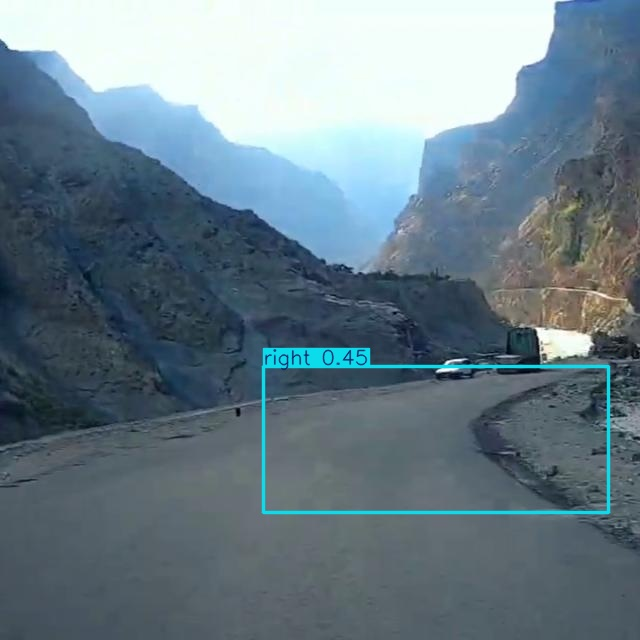

In [47]:
from IPython.display import Image
import random

# List all files in the directory
files = !ls /kaggle/working/runs/detect/predict
image_file = random.choice(files)  # Randomly pick an image file

# Display the chosen image
Image(filename=f'/kaggle/working/runs/detect/predict/{image_file}', width=600)
